In [1]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))

In [72]:
# data

rho = 1.225 # air density [kg/m3]

A = 0.2
omega = 5
alpha0_array = [5, 10, 15, 20]
V0 = 10

deltat = 0.01   
T = 2*np.pi/omega
t_array = np.arange(0, T, deltat)


delta_theta = 1
theta_array = np.deg2rad(np.arange(0, 181, delta_theta))
#theta_array = np.deg2rad(np.arange(0, 2, delta_theta))



airfoil = pd.read_csv('FFA-W3-241.txt', delim_whitespace=True, header=None,names=['aoa','cl','cd','cm','fstat', 'Cl_inv','Cl_fs'])

#blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
#r_array = blade['r'] # radius [m]
#beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
#c_array = blade['c'] # chord length [m]
#t_perc_array = blade['t_perc'] # thickness ratio [%]
#r_target = 10
c=1



In [89]:
def aerodynamic_work(alpha0, V0):

    W_array = []

    for theta in theta_array:

        Fx_array = []

        for t in t_array:
            
            x = A* np.sin(omega*t)
            x_diff = A*omega * np.cos(omega*t)

            Vy = V0 * np.cos(alpha0) + x_diff*np.cos(theta)
            Vz = V0 * np.sin(alpha0) + x_diff*np.sin(theta)
            Vrel = np.sqrt(Vy**2 + Vz**2)
            
            alpha = np.arctan(Vz / Vy)

            #c = c_array[r_target]

            Cl = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['cl'])
            Cd = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['cd'])

            l = 0.5*rho*Vrel**2 * c * Cl
            d = 0.5*rho*Vrel**2 * c * Cd
            Fx = l * np.sin(alpha - theta) - d*np.cos(alpha - theta)
            #F_x_2 = 0.5 *rho * Vrel**2 * c * (Cl * np.sin(alpha-theta) - Cd*np.cos(alpha - theta))

            Fx_array.append(Fx)

        Fx_array = np.array(Fx_array)

        W = A*omega* integrate.simpson(y=Fx_array*np.cos(omega*t_array) , x=t_array)
        
        
        W_array.append(W)
        
    return W_array

def aerodynamic_work_dynamic_stall(alpha0, V0):

    W_array = []

    for theta in theta_array:

        Fx_array = []

        fs_array = []
        fs = 0
        for t in t_array:
            
            x = A* np.sin(omega*t)
            x_diff = A*omega * np.cos(omega*t)

            Vy = V0 * np.cos(alpha0) + x_diff*np.cos(theta)
            Vz = V0 * np.sin(alpha0) + x_diff*np.sin(theta)
            Vrel = np.sqrt(Vy**2 + Vz**2)
            
            alpha = np.arctan(Vz / Vy)

            Cd = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['cd'])
            # ['aoa','cl','cd','cm','fstat', 'Cl_inv','Cl_fs']
            fstat = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['fstat'])
            Cl_inv = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['Cl_inv'])
            Cl_fs = np.interp(np.rad2deg(alpha), airfoil['aoa'], airfoil['Cl_fs'])
            
            tau = 4*c/Vrel
            fs = fstat + (fs - fstat) * np.exp(-deltat/tau)
            Cl = fs * Cl_inv + (1-fs) * Cl_fs

            fs_array.append(fs)

            
            l = 0.5*rho*Vrel**2 * c * Cl
            d = 0.5*rho*Vrel**2 * c * Cd
            Fx = l * np.sin(alpha - theta) - d*np.cos(alpha - theta)
            #F_x_2 = 0.5 *rho * Vrel**2 * c * (Cl * np.sin(alpha-theta) - Cd*np.cos(alpha - theta))

            Fx_array.append(Fx)
        
        #print(fs_array[0], fs_array[-1])

        Fx_array = np.array(Fx_array)

        W = A*omega* integrate.simpson(y=Fx_array*np.cos(omega*t_array) , x=t_array)
        
        
        W_array.append(W)
        
    return W_array





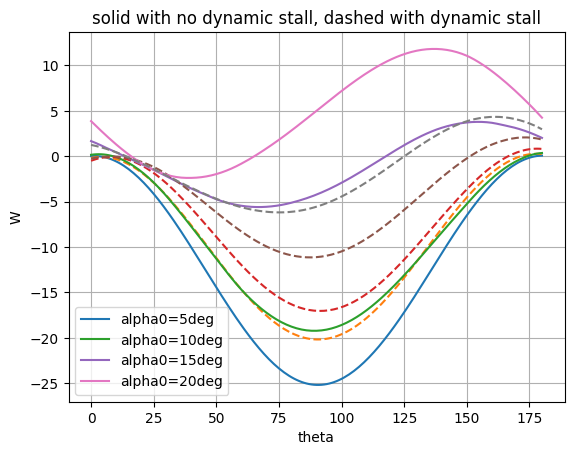

In [91]:
plt.figure(1)

for alpha0 in alpha0_array:

    name = f'alpha0={alpha0}deg'
    W_array = aerodynamic_work(np.deg2rad(alpha0), V0)
    W_array_dynamic = aerodynamic_work_dynamic_stall(np.deg2rad(alpha0), V0)
    
    plt.plot(np.rad2deg(theta_array), W_array, label=name)
    plt.plot(np.rad2deg(theta_array), W_array_dynamic, linestyle='dashed')

plt.title('solid with no dynamic stall, dashed with dynamic stall')
plt.xlabel('theta')
plt.ylabel('W')
plt.legend()
plt.grid()

plt.show()